In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.cluster import KMeans
from itertools import combinations
import random



In [172]:
# # *Note: This block will run for approximately 5 minutes

# # Dataset is from Kaggle prvided by Gamers Club: 
# #       https://www.kaggle.com/datasets/gamersclub/brazilian-csgo-plataform-dataset-by-gamers-club
# # This dataset contains statistics from 2,5k players who played more than 170k CS:GO matches.

# # ====================== Data Preprocessing ==========================
# raw_data = pd.read_csv('./Data/CSGO_data.csv') # read in dataset

# # get dummies for the categorical field 'descMapName'
# dataset = pd.get_dummies(raw_data, columns=['descMapName'])

# # remove unused columns
# unused_columns = ['idLobbyGame', 'idRoom', 'vlLevel', 'qtPlusKill']
# dataset = dataset.drop(unused_columns, axis=1)

# # ---------- check abnormal value ----------
# # # check negative values
# # is_negative = (dataset < 0).any().any()
# # if (is_negative):
# #     print("warning: negative entires exist")

# # remove abnormal data - number of hits is greater than number of shots
# dataset = dataset.drop(dataset[dataset['qtHits'] > dataset['qtShots']].index)
# # remove abnormal data - number of deaths is greater than the number of rounds
# dataset = dataset.drop(dataset[dataset['qtDeath'] > dataset['qtRoundsPlayed']].index)
# # remove abnormal data - impossible numebr of kills
# dataset = dataset.drop(dataset[dataset['qtKill'] > dataset['qtRoundsPlayed'] * 5].index)


# # --------- extract most recent 100 games for each user ----------------
# def adjust_date(date):
#     if date[6] == '/':
#         return date[0:5] + '0' + date[5:]
#     else:
#         return date

# dataset["dtCreatedAt"] = dataset["dtCreatedAt"].apply(adjust_date)

# # sort by idPlayer and date
# dataset = dataset.sort_values(by=['idPlayer', "dtCreatedAt"], ascending=[True, False], axis=0)
# dataset["gameCount"] = 1
# dataset = dataset.reset_index(drop=True)

# for index, row in dataset.iterrows():
#     if index > 0:
#         if (dataset.loc[index, "idPlayer"] == dataset.loc[index - 1, "idPlayer"]):
#             dataset.loc[index, "gameCount"] = dataset.loc[index - 1, "gameCount"] + 1
#         else:  
#             dataset.loc[index, "gameCount"] = 1

# # only preserve the most recent 100 games
# dataset = dataset.drop(dataset[dataset['gameCount'] > 100].index)

# # export
# dataset.to_csv('./Data/CSGO_recent_100.csv', index=False)

# # -----------------------------------------------------------------------

In [173]:
# # ================= Data Visulization ====================

# # ------------- histograms of KDA, ADR, HSRate and winRate ---------------
# plots = [(player_dataset['KDA'], 'KDA'), (player_dataset['ADR'], 'ADR'), \
#     (player_dataset['HSRate'], 'HSRate'), (player_dataset['winRate'], 'winRate')]

# # Create a new figure for each histogram and save it as a PNG file
# for data, filename in plots:
#     fig, ax = plt.subplots(figsize=(10, 5))
#     ax.hist(data, bins=50, color='blue')
#     ax.set_title('Histogram of ' + filename)
#     ax.set_xlabel(filename)
#     ax.set_ylabel('Frequency')
#     plt.savefig('./Plots/' + filename + '_histogram', dpi=500, bbox_inches='tight', facecolor='white')

# # ------------------------- pie chart of maps ----------------------------
# map_names = ['ancient', 'dust2', 'inferno', 'mirage', 'nuke', 'overpass', 'train', 'vertigo']
# total_games = player_dataset['gamesPlayed'].sum()
# map_percentage = [player_dataset['descMapName_de_ancient'].sum() / total_games, \
#     player_dataset['descMapName_de_dust2'].sum() / total_games, \
#         player_dataset['descMapName_de_inferno'].sum() / total_games, \
#                 player_dataset['descMapName_de_mirage'].sum() / total_games, \
#                     player_dataset['descMapName_de_nuke'].sum() / total_games, \
#                         player_dataset['descMapName_de_overpass'].sum() / total_games, \
#                             player_dataset['descMapName_de_train'].sum() / total_games, \
#                                 player_dataset['descMapName_de_vertigo'].sum() / total_games]

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.pie(map_percentage, labels=map_names, autopct='%1.1f%%', startangle=90)
# # ax.axis('equal')
# ax.set_title('Pie chart of maps')
# fig.savefig('./Plots/maps_pie_chart', dpi=500, bbox_inches='tight', facecolor='white')

# # ----------------------- scatter plot between KDA and ADR ----------------------
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.scatter(player_dataset['KDA'], player_dataset['ADR'])
# plt.title('ADR vs KDA')
# plt.xlabel('KDA')
# plt.ylabel('ADR')
# fig.savefig('./Plots/ADR_vs_KDA_scatterplot', dpi=500, bbox_inches='tight', facecolor='white')



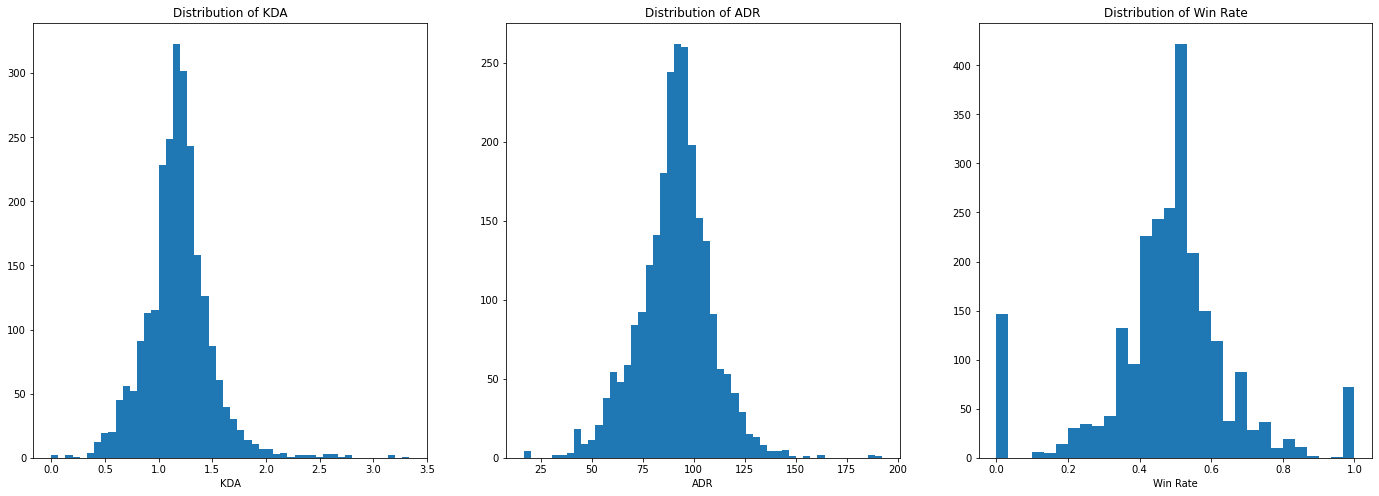

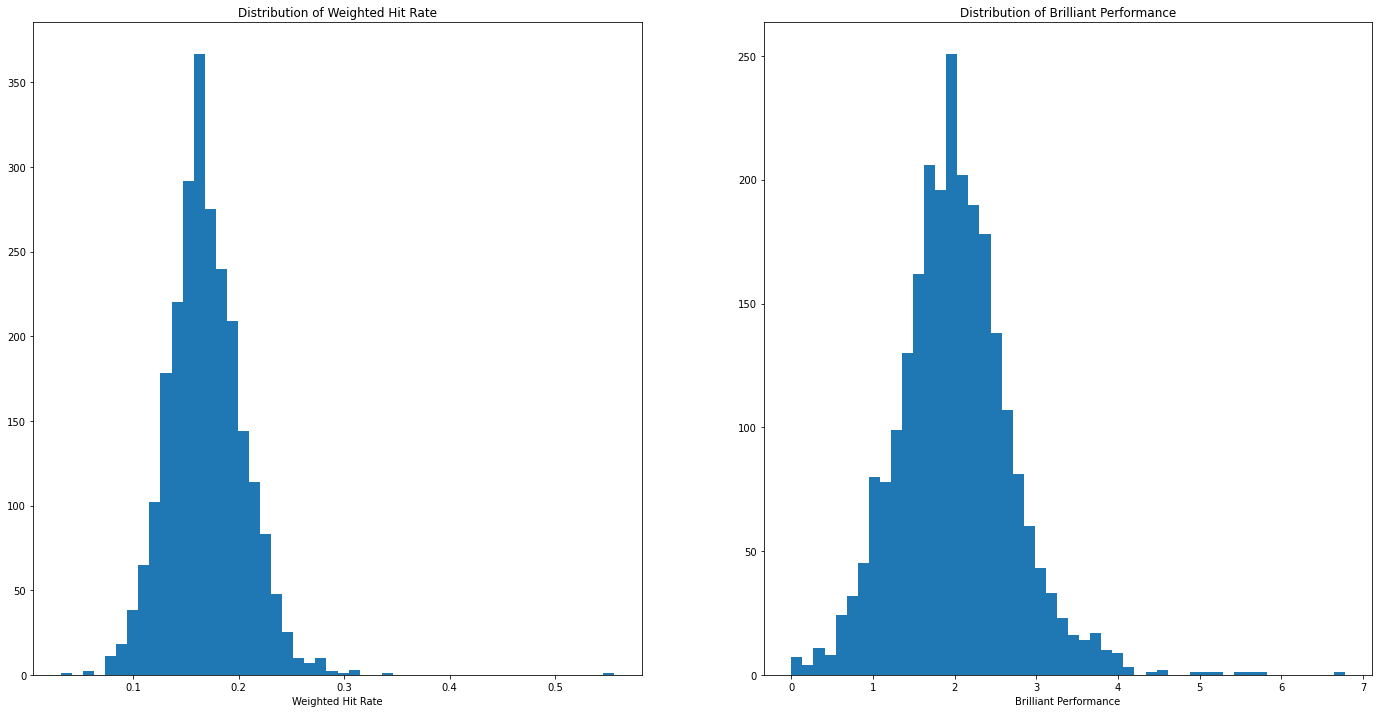

In [9]:
# ====================== Feature Engineering ==========================
dataset = pd.read_csv('./Data/CSGO_recent_100.csv')

# remove dateCreated
dataset = dataset.drop("dtCreatedAt", axis=1)
dataset = dataset.drop("gameCount", axis=1)

# group data together based on idPlayer
player_dataset = dataset.groupby('idPlayer', as_index=False).sum()
player_dataset = player_dataset.rename(columns={'flWinner': 'gamesWinned'})

# ---------- add columns that can easily be computed based on the raw data ---------
# compute and add column "KDA"
player_dataset['KDA'] = (player_dataset['qtKill'] + player_dataset['qtAssist']) / player_dataset['qtDeath']

# compute and add column "hitRate"
player_dataset['hitRate'] = player_dataset['qtHits'] / player_dataset['qtShots']

# compute and add column "ADR"
player_dataset['ADR'] = player_dataset['vlDamage'] / player_dataset['qtRoundsPlayed']

# compute and add column "HSRate"
player_dataset['HSRate'] = player_dataset['qtHitHeadshot'] / player_dataset['qtShots']

# compute and add column "gamesPlayed"
player_dataset['gamesPlayed'] = player_dataset['descMapName_de_ancient'] \
     + player_dataset['descMapName_de_dust2'] + player_dataset['descMapName_de_inferno'] \
        + player_dataset['descMapName_de_mirage'] + player_dataset['descMapName_de_nuke'] \
            + player_dataset['descMapName_de_overpass'] + player_dataset['descMapName_de_train'] \
                + player_dataset['descMapName_de_vertigo']

# compute and add column "winRate"
player_dataset['winRate'] = player_dataset['gamesWinned'] / player_dataset['gamesPlayed']

# compute and add column "weightedHitRate" 
player_dataset['weightedHitRate'] = (player_dataset['qtHs']*0.37+player_dataset['qtHitChest']*0.17\
                                     +player_dataset['qtHitStomach']*0.16+player_dataset['qtHitLeftAtm']*0.08\
                                     +player_dataset['qtHitRightArm']*0.08+player_dataset['qtHitLeftLeg']*0.07\
                                     +player_dataset['qtHitRightLeg']*0.07) / player_dataset['qtShots'] * 7

# compute and add column "brilliance"
player_dataset['brilliantPerformance'] = (0.1 * player_dataset['qt3Kill'] + 0.15 * player_dataset['qt4Kill'] + \
    0.2 * player_dataset['qt5Kill'] + 0.15 * player_dataset['qtFirstKill'] + 0.2 * player_dataset['qtHs'] + \
        0.1 * player_dataset['qtClutchWon']+ 0.1 * player_dataset['qtFlashAssist']) / player_dataset['gamesPlayed']

# -- export player_dataset
player_dataset.to_csv('./Data/player_data.csv', index=False)

# -- quick look into the data
# print(dataset.info())
# print(dataset)
# print(player_dataset.info())
# print(player_dataset)

# ---------------- Visulization of derived features --------------
KDA = player_dataset["KDA"]
ADR = player_dataset["ADR"]
WR = player_dataset["winRate"]

# distributon of KDA, ADR and WR
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
axs[0].hist(KDA, bins=50)
axs[0].set_title('Distribution of KDA')
axs[0].set_xlabel('KDA')

axs[1].hist(ADR, bins=50)
axs[1].set_title('Distribution of ADR')
axs[1].set_xlabel('ADR')

axs[2].hist(WR, bins=30)
axs[2].set_title('Distribution of Win Rate')
axs[2].set_xlabel('Win Rate')

plt.savefig('./Results/Distributions_of_KDA_ADR_WR.png', dpi=500, bbox_inches='tight', facecolor='white')

WHR = player_dataset["weightedHitRate"]
BP = player_dataset["brilliantPerformance"]

# distribution of WHR and BP and OP
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24,12))
axs[0].hist(WHR, bins=50)
axs[0].set_title('Distribution of Weighted Hit Rate')
axs[0].set_xlabel('Weighted Hit Rate')

axs[1].hist(BP, bins=50)
axs[1].set_title('Distribution of Brilliant Performance')
axs[1].set_xlabel('Brilliant Performance')

plt.savefig('./Results/Distributions_of_WHR_BP.png', dpi=500, bbox_inches='tight', facecolor='white')


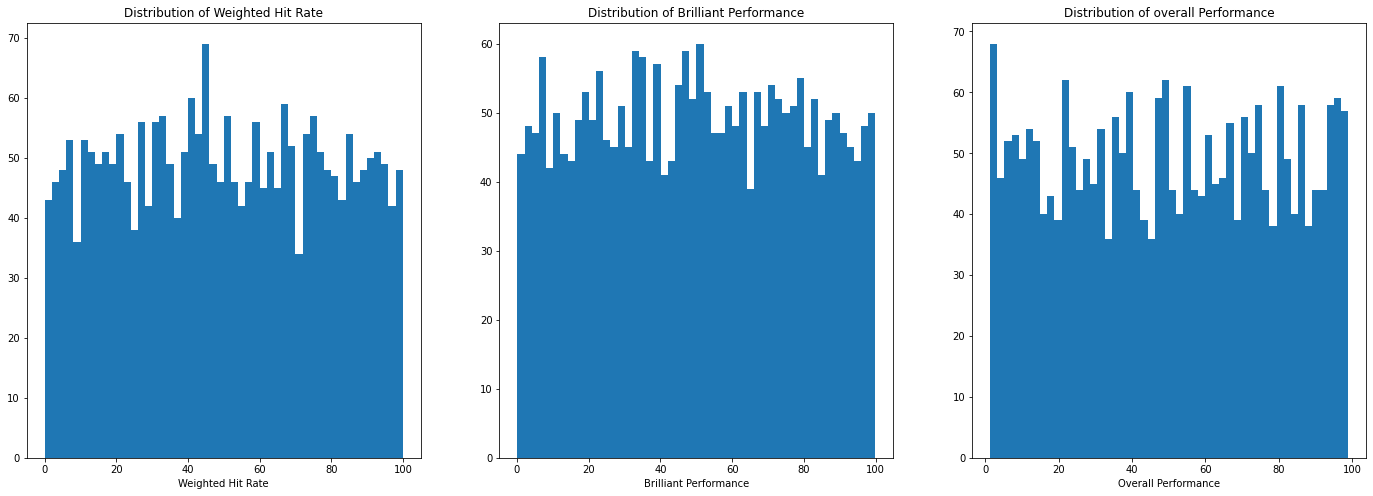

In [7]:
# ====================== Final Feature and Kernel Density Estiamtion ====================
key_features = ['idPlayer','KDA','ADR','winRate', 'weightedHitRate', 'brilliantPerformance']
final_dataset = player_dataset[key_features].copy()
key_features = key_features[1:]

# run kernel denisty estiamtions and store the result in KDEs
# Note KDEs is a dictionary, where key is the feature name and value is the corresponding KDE
KDEs = {}
for i in key_features:
    temp_data = final_dataset[i]
    temp_kde = stats.gaussian_kde(temp_data, bw_method='scott')
    KDEs[i] = temp_kde

def rate_feature(player_id,feature):
    feature_value = final_dataset[final_dataset['idPlayer'] == player_id][feature].to_numpy()
    return KDEs[feature].integrate_box_1d(-np.inf, feature_value)

# print(rate_feature(306, "brilliantPerformance"))
# print(rate_feature(3, "weightedHitRate"))
# print(rate_feature(3, "winRate"))

# =================== Final Feature =======================
# compute and add column "overallPerformance"
final_features = ['id','overallPerformance', 'weightedHitRate', 'brilliantPerformance']

final_dataset['overallPerformance'] = 0.4 * final_dataset["idPlayer"].apply(lambda x: rate_feature(x, feature="KDA")) + \
    0.4 * final_dataset["idPlayer"].apply(lambda x: rate_feature(x, feature="ADR")) + \
        0.2 * final_dataset["idPlayer"].apply(lambda x: rate_feature(x, feature="winRate"))

overallPerformance = final_dataset['overallPerformance']
OP_kde = stats.gaussian_kde(overallPerformance, bw_method='scott')
KDEs['overallPerformance'] = OP_kde

for i in final_features[1:]:
    final_dataset[i + "_normalized"] = final_dataset["idPlayer"].apply(lambda x: rate_feature(x, feature=i))
    final_dataset[i + "_normalized"] = final_dataset[i + "_normalized"] * 100

final_dataset = final_dataset.drop(key_features, axis=1)

for i in final_features[1:]:
    final_dataset[i] = final_dataset[i + "_normalized"]
    final_dataset = final_dataset.drop(i + "_normalized", axis=1)


final_dataset.to_csv('./Data/final_data.csv', index=False)


# --------------------- visulization ---------------------------
# WHR = final_dataset["weightedHitRate"]
# BP = final_dataset["brilliantPerformance"]
# OP = final_dataset["overallPerformance"]
# # distribution of WHR and BP and OP
# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
# axs[0].hist(WHR, bins=50)
# axs[0].set_title('Distribution of Weighted Hit Rate')
# axs[0].set_xlabel('Weighted Hit Rate')

# axs[1].hist(BP, bins=50)
# axs[1].set_title('Distribution of Brilliant Performance')
# axs[1].set_xlabel('Brilliant Performance')

# axs[2].hist(OP, bins=50)
# axs[2].set_title('Distribution of overall Performance')
# axs[2].set_xlabel('Overall Performance')

# plt.savefig('./Results/Distributions_of_WHR_BP_OP.png', dpi=500, bbox_inches='tight', facecolor='white')


In [7]:
# ======================= Fariness fucntions ================================
def rate_player(player_id):
    r_BP = final_dataset[final_dataset['idPlayer'] == player_id]["brilliantPerformance"]
    r_WHR = final_dataset[final_dataset['idPlayer'] == player_id]["weightedHitRate"]
    r_OP = final_dataset[final_dataset['idPlayer'] == player_id]["overallPerformance"]
    return (0.5 * r_OP + 0.35 * r_BP + 0.15 * r_WHR).to_numpy()[0]


# parameter t: an array containing 5 player_id in the team
def rate_team(t):
    # get individual ratings of those 5 players
    r = []
    for i in t:
        temp = rate_player(i)
        r.append(temp)
    
    # calculate team rating
    r.sort()
    return 0.35 * r[4] + 0.2 * r[0] + 0.15 * (r[1] + r[2] + r[3])


def rate_match(t_1, t_2):
    return abs(rate_team(t_1) - rate_team(t_2))

# lm is an array of length 10, indicating 10 players in one game
def team_match(lm):
    combs = combinations(lm, 5)
    local_match = []
    local_match_fairness = 0
    temp = 100
    for c in combs:
        t_1 = list(c)
        t_2 = [i for i in lm if i not in t_1]
        match_score = rate_match(t_1, t_2)
        if (match_score < temp):
            temp = match_score
            local_match = [t_1, t_2]
            local_match_fairness = match_score
    return local_match, local_match_fairness
        

# M is the global matchmaking result
def rate_matchmaking(M):
    all_game_fairness = []
    global_fairness = 0
    for i in M.values():
        local_match, local_match_fairness = team_match(i)
        all_game_fairness.append(local_match_fairness)
        if (local_match_fairness > global_fairness):
            global_fairness = local_match_fairness
    return global_fairness, all_game_fairness


# sample testing
# print(rate_player(1))
# t1 = [1,2,3,4,5]
# t2 = [6,7,8,9,10]
# print(rate_team(t1))
# print(rate_team(t2))
# print(rate_match(t1,t2))

x = [1,2,3,4,5,6,7,8,9,10]
local_match, local_match_fairness = team_match(x)
print(local_match_fairness)
print(local_match)
for i in local_match:
    for j in i:
        print(rate_player(j))
# plt.hist(all_matches, bins=20)


0.23085407001973834
[[1, 2, 6, 7, 9], [3, 4, 5, 8, 10]]
20.695937715341714
10.13901409798643
70.60831734380548
22.30607486951181
85.40987197220886
67.06930006875069
7.4855952880200896
63.438542935292126
4.908356886858992
78.60849842287925


In [77]:
# ======================= Player Grade Labelling ================================
final_dataset["player_rate"] = final_dataset["idPlayer"].apply(rate_player)
rate_kde = stats.gaussian_kde(final_dataset["player_rate"], bw_method='scott')

def grade_label(player_id):
    r = final_dataset[final_dataset['idPlayer'] == player_id]["player_rate"].to_numpy()
    rank = rate_kde.integrate_box_1d(-np.inf, r)

    if (rank <= 0.1):
        return 'G'
    elif (0.1 < rank <= 0.26):
        return 'F'
    elif (0.26 < rank <= 0.42):
        return 'E'
    elif (0.42 < rank <= 0.58):
        return 'D'
    elif (0.58 < rank <= 0.74):
        return 'C'
    elif (0.74 < rank <= 0.9):
        return 'B'
    elif (0.9 < rank):
        return 'A'

final_dataset["grade"] = final_dataset["idPlayer"].apply(grade_label)
final_dataset = final_dataset.drop("player_rate", axis=1)

player_dataset["grade"] = final_dataset.loc[player_dataset["idPlayer"] == final_dataset["idPlayer"], "grade"]

player_dataset.to_csv("./Data/player_data_with_grade.csv", index=False)
final_dataset.to_csv('./Data/final_data_with_grade.csv', index=False)


In [30]:
# Edison: Grade Classifier(LogisticRegression)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# read data
data = pd.read_csv('./Data/player_data_with_grade.csv', header = 0)

# record all features
column_names = ['idPlayer','qtKill','qtAssist','qtDeath','qtHs','qtBombeDefuse','qtBombePlant',
                'qtTk','qtTkAssist','qt1Kill','qt2Kill','qt3Kill','qt4Kill','qt5Kill','qtFirstKill',
                'vlDamage','qtHits','qtShots','qtLastAlive','qtClutchWon','qtRoundsPlayed','qtSurvived',
                'qtTrade','qtFlashAssist','qtHitHeadshot','qtHitChest','qtHitStomach','qtHitLeftAtm',
                'qtHitRightArm','qtHitLeftLeg','qtHitRightLeg','gamesWinned','descMapName_de_ancient',
                'descMapName_de_dust2','descMapName_de_inferno','descMapName_de_mirage','descMapName_de_nuke',
                'descMapName_de_overpass','descMapName_de_train','descMapName_de_vertigo','KDA','hitRate',
                'ADR','HSRate','gamesPlayed','winRate','weightedHitRate','brilliantPerformance','grade'
]

# cutting data into trainning set and testing set（25%）
X_train, X_test, y_train, y_test = train_test_split(data[column_names[1:48]],
                                                    data[column_names[48]], 
                                                    test_size=0.25, random_state=33)
# Standardized data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

# Rename LR
lr = LogisticRegression(max_iter=1000000)

# Use LR to consolidate forecast data
lr.fit(X_train, y_train)
lr_y_predict = lr.predict(X_test)
lr_y_predict_proba = lr.predict_proba(X_test)

# this function is preparing for testing the effect of the prediction
print('Accuracy of LR Classifier:', lr.score(X_test, y_test))
# print(classification_report(y_test, lr_y_predict, target_names=['A','B','C','D','E','F','G']))
# print(lr_y_predict)




Accuracy of LR Classifier: 0.7925445705024311


In [48]:
# # # ========================= Kmeans ===========================

# # parameter: player_data is a dataframe
# def KMeans_matchmaking(player_data, cluster_size=10):
#     player_data = player_data.reset_index(drop=True)
#     feature_data = player_data.drop(['grade', 'idPlayer'],axis=1)
#     c_data = feature_data.to_numpy()

#     n_clusters = len(c_data) // cluster_size
#     kmeans = KMeans(n_clusters=n_clusters).fit(c_data)

#     # Re-assign data points to clusters to ensure that each cluster has the desired size
#     labels = kmeans.labels_
#     cluster_counts = np.bincount(labels)

#     for i in range(len(cluster_counts)):
#         while cluster_counts[i] > cluster_size:
#             # Find the data point farthest from the centroid of the current cluster
#             distances = np.linalg.norm(c_data[kmeans.labels_ == i] - kmeans.cluster_centers_[i], axis=1)
#             farthest_point_index = np.argmax(distances)

#             original_index = 0
#             cur = -1
#             for j in range(len(labels)):
#                 if labels[j] == i:
#                     cur += 1
#                     if (cur == farthest_point_index):
#                         original_index = j
#                         break

            
#             # Assign the farthest point to the nearest underfull cluster
#             underfull_clusters = np.where(cluster_counts < cluster_size)[0]
#             distances_to_underfull_clusters = np.linalg.norm(c_data[underfull_clusters] - c_data[kmeans.labels_ == i][farthest_point_index], axis=1)
#             nearest_underfull_cluster = underfull_clusters[np.argmin(distances_to_underfull_clusters)]
#             labels[original_index] = nearest_underfull_cluster
            
#             # Update the cluster counts
#             cluster_counts[i] -= 1
#             cluster_counts[nearest_underfull_cluster] += 1

#     # Print the cluster assignments and centroids
#     # print("Cluster assignments:", labels)
#     # print("Cluster centroids:", kmeans.cluster_centers_)
#     # print("cluster counts:", cluster_counts)

#     def retrive_idPlayer(index):
#         return player_data.loc[index]["idPlayer"]

#     global_match = {}
#     for i in range(max(labels) + 1):
#         global_match[str(i)] = []
        
#     for i in range(len(labels)):
#         global_match[str(labels[i])].append(retrive_idPlayer(i))

#     return global_match


# # ----------- clustering testing ------------
# # sample_data = pd.read_csv('./Data/final_data_with_grade.csv')
# # sample_data = sample_data[sample_data['grade'] == "C"]
# # sample_data = sample_data[1:]
# # sample_data = sample_data.reset_index(drop=True)

# # global_match = KMeans_matchmaking(sample_data)
# # print(global_match)
# # ------------------------------------------------

# # global_fairness, all_fairness = rate_matchmaking(global_match)
# # print(global_fairness)
# # plt.hist(all_fairness, bins=40)


In [49]:
# =================== Random Matching =========================
def random_matchmaking(id_data):
    data = id_data.to_numpy()
    random.shuffle(data)
    # Split the shuffled data into 40 groups, each containing 10 data points
    groups = [data[i:i+10] for i in range(0, len(data), 10)]
    # Split each group into 2 arrays, each of size 5
    random_groups = [[g[:5], g[5:]] for g in groups]

    return random_groups

def random_fairness_evaluate(groups):
    global_fairness = 0
    all_fairness = []
    for i in groups:
        t1 = i[0]
        t2 = i[1]
        game_fairness = rate_match(t1, t2)
        all_fairness.append(global_fairness)
        if (game_fairness > global_fairness):
            global_fairness = game_fairness
    return global_fairness, all_fairness


# ---------------- random testing ------------------
# sample_data = pd.read_csv('./Data/final_data_with_grade.csv')
# sample_data = sample_data[sample_data['grade'] == "C"]
# sample_data = sample_data[1:]
# data = sample_data["idPlayer"]
# global_match = random_matchmaking(data)
# print(global_match)
# global_fairness, all_fairness = random_fairness_evaluate(global_match)
# print(global_fairness)
# plt.hist(all_fairness, bins=40)


In [46]:
# # ========================= Input data for clustering ================================

# sample_data = pd.read_csv('./Data/final_data_with_grade.csv')
# a_data = sample_data[sample_data['grade'] == "A"]
# b_data = sample_data[sample_data['grade'] == "B"]
# c_data = sample_data[sample_data['grade'] == "C"]
# d_data = sample_data[sample_data['grade'] == "D"]
# e_data = sample_data[sample_data['grade'] == "E"]
# f_data = sample_data[sample_data['grade'] == "F"]
# g_data = sample_data[sample_data['grade'] == "G"]

# # only consider multiple of 10 players
# a_data = a_data[9:]
# b_data = b_data[8:]
# c_data = c_data[1:]
# d_data = d_data[1:]
# e_data = e_data[5:]
# f_data = f_data[6:]
# g_data = g_data[7:]

# a_data = a_data.reset_index(drop=True)
# b_data = b_data.reset_index(drop=True)
# c_data = c_data.reset_index(drop=True)
# d_data = d_data.reset_index(drop=True)
# e_data = e_data.reset_index(drop=True)
# f_data = f_data.reset_index(drop=True)
# g_data = g_data.reset_index(drop=True)

# batches = [a_data, b_data, c_data, d_data, e_data, f_data, g_data]



In [74]:
# # ============================= Results ===================================
# #  Note:
# #   In the final results, for each batch, 3 values are recorded:
# #       (1) matchmaking results (2) maximum fairness measure (3) fairness measure of all games
# #   For instance, I want the fairness measure of all games in Grade A, it can be accessed by:
# #       Kmeans_match_results['0'][2]
# #   The key of the dictionary has the following corresponding relation: A:0, B:1, C:2, etc.

# Kmeans_match_results = {}
# for i in range(len(batches)):
#     Kmeans_match_results[str(i)] = []

# random_match_results = {}
# for i in range(len(batches)):
#     random_match_results[str(i)] = []

# # Kmeans results
# for i in range(len(batches)):
#     # get global match result
#     global_match = KMeans_matchmaking(batches[i])
#     Kmeans_match_results[str(i)].append(global_match)
#     # find optimum team assignements in each game, report the final fairness
#     global_fairness, all_fairness = rate_matchmaking(global_match)
#     Kmeans_match_results[str(i)].append(global_fairness)
#     Kmeans_match_results[str(i)].append(all_fairness)

    
# # random results
# for i in range(len(batches)):
#     data = batches[i]["idPlayer"]
#     global_match = random_matchmaking(data)
#     random_match_results[str(i)].append(global_match)
#     global_fairness, all_fairness = random_fairness_evaluate(global_match)
#     random_match_results[str(i)].append(global_fairness)
#     random_match_results[str(i)].append(all_fairness)




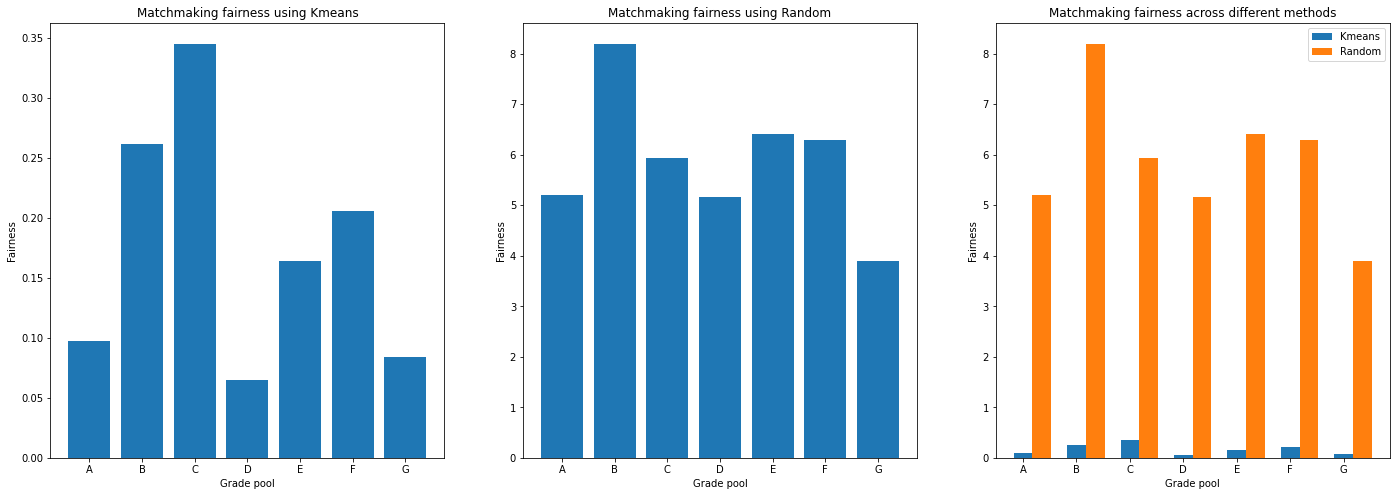

In [89]:
# # ============================ Results visualization1: bar chart =======================
# # print(Kmeans_match_results)
# # print(random_match_results)

# # for i in range(0, 7):
# #     print(Kmeans_match_results[str(i)][1])
# # for i in range(0, 7):
# #     print(random_match_results[str(i)][1])

# # barchart of fairness in each grade in Kmeans and random
# x = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
# for i in range(0,7):
#     y1 = []
#     y2 = []
#     for j in range(len(batches)):
#         y1.append(Kmeans_match_results[str(j)][1])
#         y2.append(random_match_results[str(j)][1])

# bar_width = 0.35

# # Create arrays for the X-axis positions of the bars
# x_pos1 = np.arange(len(x))
# x_pos2 = [x + bar_width for x in x_pos1]

# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
# # Create the bar chart with two sets of bars per label
# axs[0].bar(x, y1)
# axs[1].bar(x, y2)
# axs[2].bar(x, y1, width=bar_width, label='Kmeans')
# axs[2].bar(x_pos2, y2, width=bar_width, label='Random')

# # Set the chart title, axis labels, and legend
# axs[0].set_title('Matchmaking fairness using Kmeans')
# axs[0].set_xlabel('Grade pool')
# axs[0].set_ylabel('Fairness')

# axs[1].set_title('Matchmaking fairness using Random')
# axs[1].set_xlabel('Grade pool')
# axs[1].set_ylabel('Fairness')

# axs[2].set_title('Matchmaking fairness across different methods')
# axs[2].set_xlabel('Grade pool')
# axs[2].set_ylabel('Fairness')
# axs[2].legend()

# # Save the chart as a PNG file
# plt.savefig('./Results/fairness_bar_chart.png', dpi=500, bbox_inches='tight', facecolor='white')



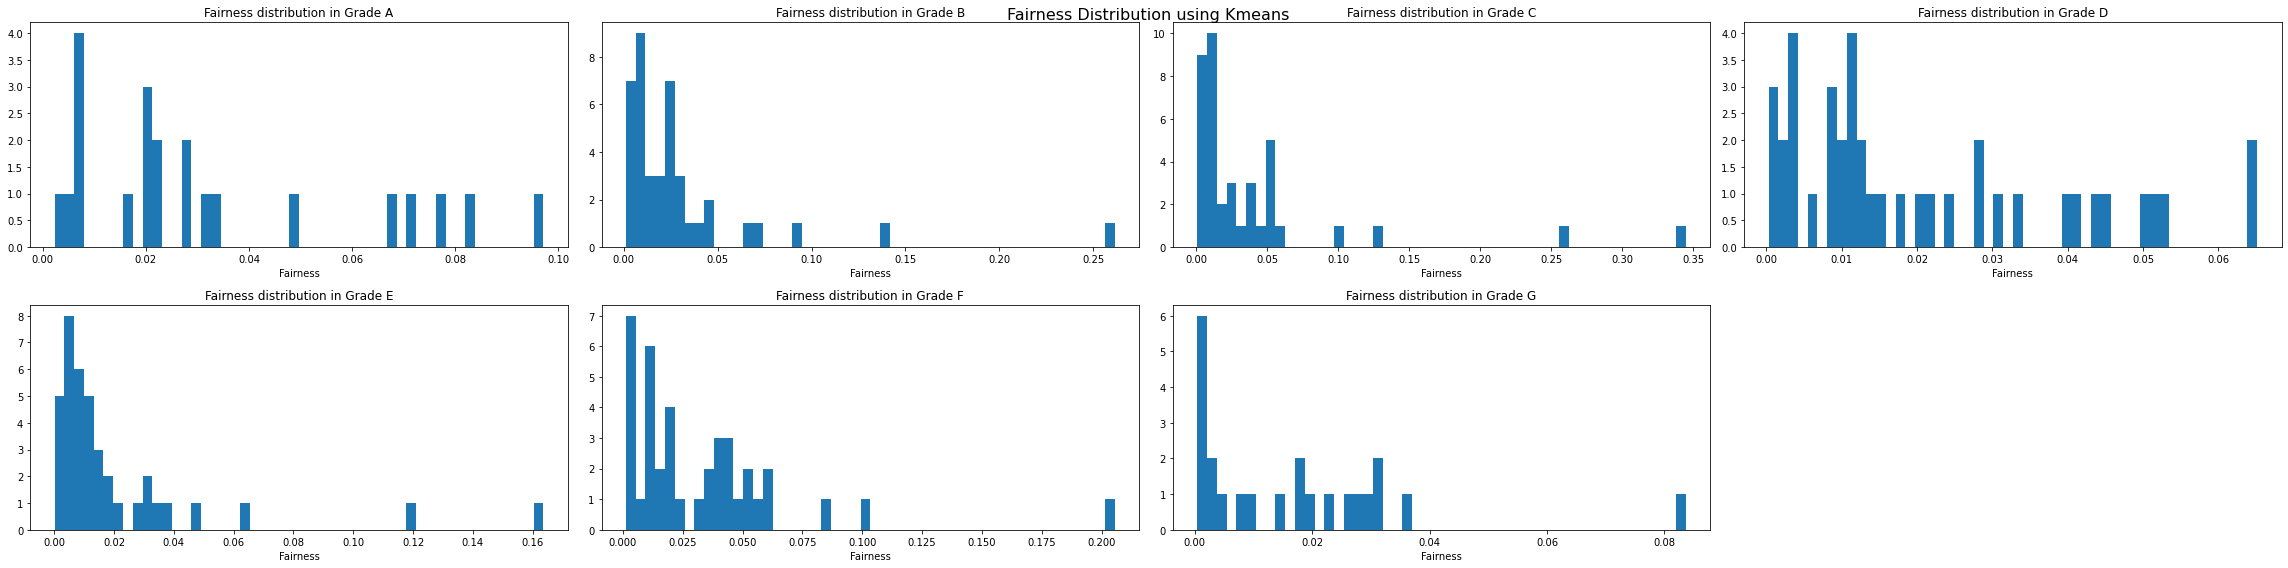

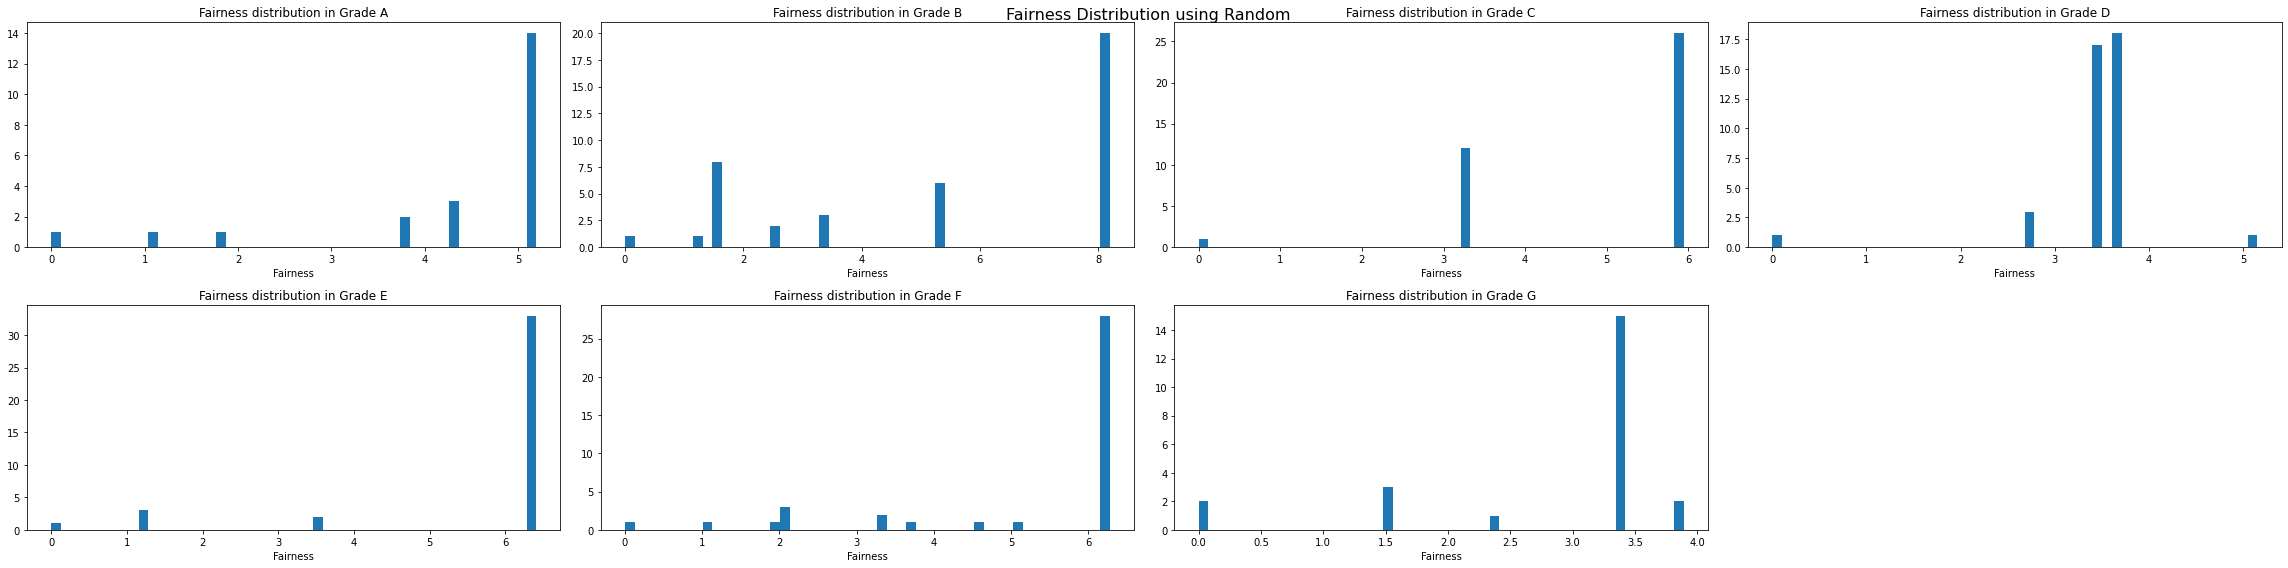

In [76]:
# # ============================ Results visualization1: histograms =======================
# # distribution of fairness of each grade in Kmeans
# fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(32,8))
# a_dis = Kmeans_match_results['0'][2]
# b_dis = Kmeans_match_results['1'][2]
# c_dis = Kmeans_match_results['2'][2]
# d_dis = Kmeans_match_results['3'][2]
# e_dis = Kmeans_match_results['4'][2]
# f_dis = Kmeans_match_results['5'][2]
# g_dis = Kmeans_match_results['6'][2]

# axs[0][0].hist(a_dis, bins=50)
# axs[0][0].set_title('Fairness distribution in Grade A')
# axs[0][0].set_xlabel('Fairness')

# axs[0][1].hist(b_dis, bins=50)
# axs[0][1].set_title('Fairness distribution in Grade B')
# axs[0][1].set_xlabel('Fairness')

# axs[0][2].hist(c_dis, bins=50)
# axs[0][2].set_title('Fairness distribution in Grade C')
# axs[0][2].set_xlabel('Fairness')

# axs[0][3].hist(d_dis, bins=50)
# axs[0][3].set_title('Fairness distribution in Grade D')
# axs[0][3].set_xlabel('Fairness')

# axs[1][0].hist(e_dis, bins=50)
# axs[1][0].set_title('Fairness distribution in Grade E')
# axs[1][0].set_xlabel('Fairness')

# axs[1][1].hist(f_dis, bins=50)
# axs[1][1].set_title('Fairness distribution in Grade F')
# axs[1][1].set_xlabel('Fairness')

# axs[1][2].hist(g_dis, bins=50)
# axs[1][2].set_title('Fairness distribution in Grade G')
# axs[1][2].set_xlabel('Fairness')

# fig.tight_layout()
# fig.suptitle('Fairness Distribution using Kmeans', fontsize=16)
# axs[1][3].set_visible(False)
# plt.savefig('./Results/Kmeans_fairness_distribution.png', dpi=500, bbox_inches='tight', facecolor='white')


# # distribution of fairness of each grade in random
# fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(32,8))
# a_dis = random_match_results['0'][2]
# b_dis = random_match_results['1'][2]
# c_dis = random_match_results['2'][2]
# d_dis = random_match_results['3'][2]
# e_dis = random_match_results['4'][2]
# f_dis = random_match_results['5'][2]
# g_dis = random_match_results['6'][2]

# axs[0][0].hist(a_dis, bins=50)
# axs[0][0].set_title('Fairness distribution in Grade A')
# axs[0][0].set_xlabel('Fairness')

# axs[0][1].hist(b_dis, bins=50)
# axs[0][1].set_title('Fairness distribution in Grade B')
# axs[0][1].set_xlabel('Fairness')

# axs[0][2].hist(c_dis, bins=50)
# axs[0][2].set_title('Fairness distribution in Grade C')
# axs[0][2].set_xlabel('Fairness')

# axs[0][3].hist(d_dis, bins=50)
# axs[0][3].set_title('Fairness distribution in Grade D')
# axs[0][3].set_xlabel('Fairness')

# axs[1][0].hist(e_dis, bins=50)
# axs[1][0].set_title('Fairness distribution in Grade E')
# axs[1][0].set_xlabel('Fairness')

# axs[1][1].hist(f_dis, bins=50)
# axs[1][1].set_title('Fairness distribution in Grade F')
# axs[1][1].set_xlabel('Fairness')

# axs[1][2].hist(g_dis, bins=50)
# axs[1][2].set_title('Fairness distribution in Grade G')
# axs[1][2].set_xlabel('Fairness')

# fig.tight_layout()
# fig.suptitle('Fairness Distribution using Random', fontsize=16)
# axs[1][3].set_visible(False)
# plt.savefig('./Results/random_fairness_distribution.png', dpi=500, bbox_inches='tight', facecolor='white')




